In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
'''
!pip install kaggle
'''

'\n!pip install kaggle\n'

In [ ]:
'''
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/프로젝트/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
'''

'\n!mkdir -p ~/.kaggle\n!cp /content/drive/MyDrive/프로젝트/kaggle.json ~/.kaggle\n!chmod 600 ~/.kaggle/kaggle.json\n'

In [ ]:
'''
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
'''

'\n!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia\n'

In [ ]:
'''
!unzip chest-xray-pneumonia.zip -d /content/drive/MyDrive/프로젝트/chest-xray-pneumonia
'''

'\n!unzip chest-xray-pneumonia.zip -d /content/drive/MyDrive/프로젝트/chest-xray-pneumonia\n'

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import datetime

## 수집한 데이터의 정보
>데이터 내용: 5년간 광저우 여성-어린이 의료 센터에서 수집한 5863장의 폐의 엑스레이 사진으로, 폐렴에 걸린 폐 사진과 건강한 폐의 사진 2개의 분류가 되어있는 데이터셋

데이터 출처: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


Found 5216 images belonging to 2 classes.


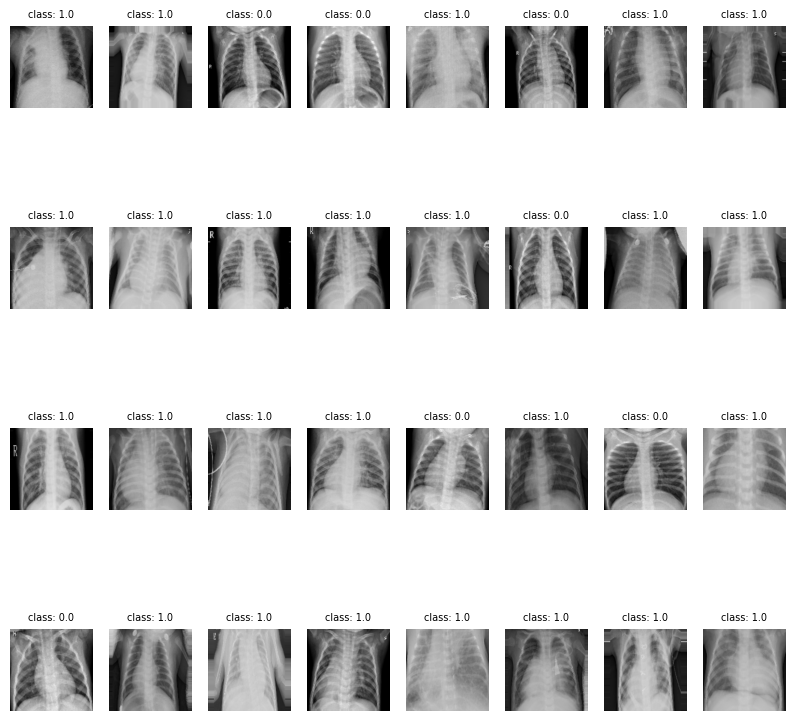

In [ ]:


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

def imshow(img,lab):

  plt.figure(figsize = (10,10))
  for i in range(len(img)):
    plt.subplot(4,8,i+1)
    plt.imshow(img[i])
    plt.title(f"class: {lab[i]}",fontsize=7)
    plt.axis('off')
  plt.show()



train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_dir = "/content/drive/MyDrive/프로젝트/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/drive/MyDrive/프로젝트/chest-xray-pneumonia/chest_xray/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
images,labels = train_generator.next()
imshow(images,labels)

## 데이터 전처리
기존의 데이터가 각각 이미지 크기가 달라서 224x224로 고정시키고, 폐렴데이터인지 아닌지 라벨링하는 과정을 거침

In [ ]:


class CustomDataset(Dataset):
    def __init__(self, root_dir):
        # Set the root directory where the dataset is located
        self.root_dir = root_dir
        # Get the list of class (label) names from the subdirectories in the root directory
        self.classes = os.listdir(root_dir)
        # Define a series of image transformations using torchvision.transforms.Compose
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
            transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        ])
        # Lists to store file paths and corresponding labels
        self.data = []
        self.labels = []

        # Loop through each class and collect file paths and labels
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            # Iterate through files in each class
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                # Append file path and label to the respective lists
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the file path and label for the given index
        img_path = self.data[idx]
        label = self.labels[idx]

        # Open the image using the PIL library and convert it to RGB format
        img = Image.open(img_path).convert('RGB')

        # Apply the defined transformations to preprocess the image
        img = self.transform(img)

        # Return the preprocessed image and its corresponding label
        return img, label
train_dataset = CustomDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = CustomDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=True)

 ## CNN모델
1.  conv1에서는 컨볼루션 연산을 통해 사진의 rgb값을 16개의 특징으로 나누어 이미지를 분석  
  - kermel_size는 이미지를 훑는 데 사용하는 격자의 크기
  - stride는 훑을 때 이동하는 격자의 수
  - padding은 이미지의 가장자리를 채우는 빈 공간의 크기를 의미

2.  conv2에서는 컨볼루션 연산을 통해 16개의 특징을 다시 32개의 특징으로 나누어 분석
3.  폴딩된 이미지 평탄화(2차원의 값을 1차원으로 내리는 과정)
4.  fc1에서 32x32x56개의 특성을 128개로, fc2에서 128개의 특성을 2개(폐렴의 유무)로 줄임

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 2, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)
    self.flatten = nn.Flatten()
    h_after_conv2 = 56
    w_after_conv2 = 56
    self.fc1 = nn.Linear(32 * h_after_conv2 * w_after_conv2,128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self,x):
    x = torch.relu(self.conv1(x))
    x = torch.relu(self.conv2(x))
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)

    return x

In [ ]:
class CNN2(nn.Module):
  def __init__(self):
    super(CNN2,self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
    self.flatten = nn.Flatten()
    h_after_conv2 = 56
    w_after_conv2 = 56
    self.fc1 = nn.Linear(64 * h_after_conv2 * w_after_conv2,128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self,x):
    x = torch.relu(self.conv1(x))
    x = torch.relu(self.conv2(x))
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)

    return x

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 추가된 합성곱 레이어
        self.flatten = nn.Flatten()
        h_after_conv3 = 28  # 새로운 합성곱 레이어에 따른 높이의 변화에 따라 조정
        w_after_conv3 = 28  # 새로운 합성곱 레이어에 따른 높이의 변화에 따라 조정
        self.fc1 = nn.Linear(64 * h_after_conv3 * w_after_conv3, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# 모델 인스턴스 생성
model = CNN3()

# 모델의 아키텍처 출력
print(model)

CNN3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


$ outputsize = [\frac{input_size+2 * padding - kernal_size}{stride}] $



In [ ]:
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 추가된 합성곱 레이어
        self.flatten = nn.Flatten()
        h_after_conv3 = 28
        w_after_conv3 = 28  # 새로운 합성곱 레이어에 따른 높이의 변화에 따라 조정

        self.fc1 = nn.Linear(128 * h_after_conv3 * w_after_conv3, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)

        x = torch.relu(self.conv3(x))
        x = self.dropout(x)

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)

        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

# 모델 인스턴스 생성
model = CNN4()

# 모델의 아키텍처 출력
print(model)

CNN4(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## 정확도 계산 함수

> 이 함수는 학습된 모델의 결과의 정확도를 계산하는 함수로 아 정확도를 계산하는 함수로 아래와 같은 식으로 계산한다.

$ acc = \frac{N_{{pred}={real}}}{All Dataset count} $  
$ N_{{pred}={real}}: 예측 데이터와 실제 데이터 값이 같은 데이터의 수 $

In [ ]:
def check(chkmodel,loader):
  cnt = 0
  chkmodel.eval()
  with torch.no_grad():
    dataiter = iter(loader)
    images, labels = dataiter.__next__()

    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    _, predicted = torch.max(outputs,1)

    for i in range(len(images)):
      if predicted[i] == labels[i]:
        cnt+=1


  chkmodel.train()
  return cnt/len(images)


## Epoch란?
학습 모델 구현을 위해 데이터셋을 학습시킨 횟수

In [ ]:
date = datetime.datetime.now()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN4().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


epoch = 8
df = pd.DataFrame({
      "Epoch" : [],
      "Loss" : [],
      "Accuracy_train" : [],
      "Accuracy_test" : []
})

path = f"/content/drive/MyDrive/프로젝트/result/chest-xray-pneumonia {date}.csv"

for e in range(epoch):
  loss = 0.0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss_val = criterion(outputs, labels)
    loss_val.backward()
    optimizer.step()
    loss += loss_val.item()
  print(f"Epoch [{e+1}/{epoch}], Loss: {loss / len(train_loader)}, Accuracy_train: {check(model,train_loader)}, Accuracy_test: {check(model,test_loader)}")
  df2 = pd.DataFrame({
    "Epoch" : [e+1],
    "Loss" : [loss / len(train_loader)],
    "Accuracy_train" : [check(model,train_loader)],
    "Accuracy_test" : [check(model,test_loader)]
    })
  df = pd.concat([df,df2])
  print()

df.to_csv(path, index = False)

Epoch [1/8], Loss: 0.5040369788927535, Accuracy_train: 0.9375, Accuracy_test: 0.75

Epoch [2/8], Loss: 0.29150432663644016, Accuracy_train: 0.9375, Accuracy_test: 0.6875



## 데이터 분석 결과
- train 데이터의 경우 정확도가 93%에서 100%까지 상당히 높고 차이가 적은 정확도를 보이는 반면 test 데이터는 65%부터 84%까지 큰 차이를 보이고, 정확도 자체도 train 데이터보다 낮다. test 데이터의 정확도가 train 데이터보다 낮은 이유는 Ai가 train 데이터를 이용해 학습을 하였기 떄문이다. 값을 보면 Epoch 3과 4가 Epoch 2에 비해 더 많은 학습을 하였는데 낮은 정확도를 띈다. 이런 현상을 과적합이라고 하는데, 과적합이란 train 데이터를 기반으로 학습할 때 분류하는 기준을 너무 세세하게 잡아서 train 데이터만 제대로 분류하게 되는 현상이다. 위 학습 모델의 경우에도 Epoch 3과 4에서 과적합이 일어나서 정확도가 떨어지게 되고, Epoch 5에서는 더 많은 학습을 통해 과적합에서 벗어나게 되었다.
- 그래프로 그려지는 결과 중에 Loss라는 값이 있는데, 이것은 손실률을 의미한다. 손실률은 실제 데이터와 학습 모델의 예측값과의 차이를 나타내는 지표이다. Epoch 값이 증가할수록 손실률은 감소하게 되는데, 손실률이 낮으면 대체로 더 좋은 학습 모델이라고 할 수 있지만, 손실률이 특정 값 아래로 내려가면 그때부터는 손실률이 더 작은 모델이라고 해서 반드시 더 좋은 모델이 아닐 수 있다. 그 이유는 train 데이터를 이용하여 모델을 학습시키기 때문에 새로운 데이터가 들어왔을 때 모델이 학습한 내용과 일부분 다를 수 있기 때문이다.

0
/content/drive/MyDrive/프로젝트/result/chest-xray-pneumonia 2024-02-25 07_18_35.728812.csv


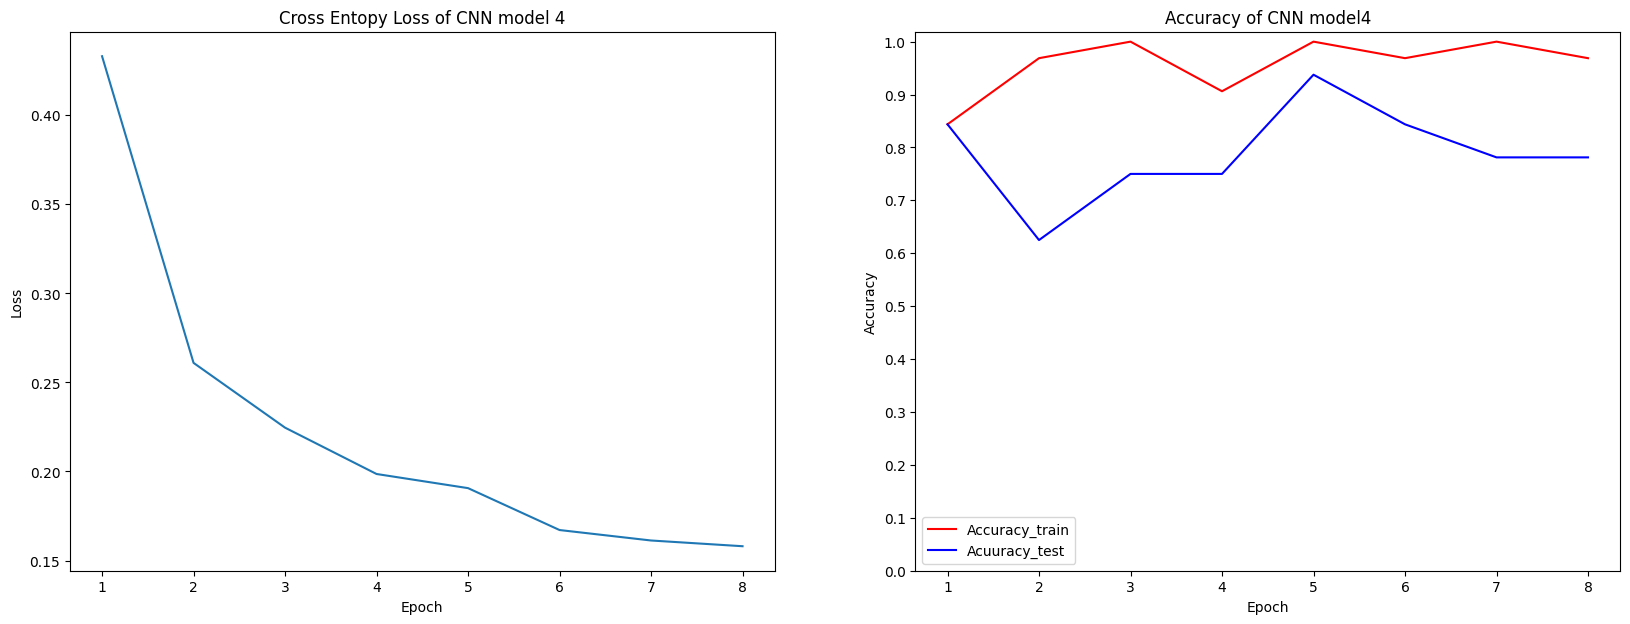

In [ ]:

folder_path = "/content/drive/MyDrive/프로젝트/result"
file_list = os.listdir(folder_path)
file_num = int(input())

print(f"{folder_path}/{file_list[file_num]}")
data = pd.read_csv(f"{folder_path}/{file_list[file_num]}")

x = data["Epoch"]
y1 = data["Loss"]
y2 = data["Accuracy_train"]
y3 = data["Accuracy_test"]
plt.figure(figsize = (20,7))

plt.subplot(1,2,1)
plt.title("Cross Entopy Loss of CNN model 4")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y1)

plt.subplot(1,2,2)
plt.plot(x, y2, color = "red", label = "Accuracy_train")
plt.plot(x, y3, color = "blue", label = "Acuuracy_test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.yticks([i * 0.1 for i in range(11)])
plt.xticks([(i+1) * 1.0 for i in range(len(data["Epoch"]))])
plt.legend()
plt.title("Accuracy of CNN model4")
plt.savefig(f"{folder_path}/graph{file_num}")
plt.show()

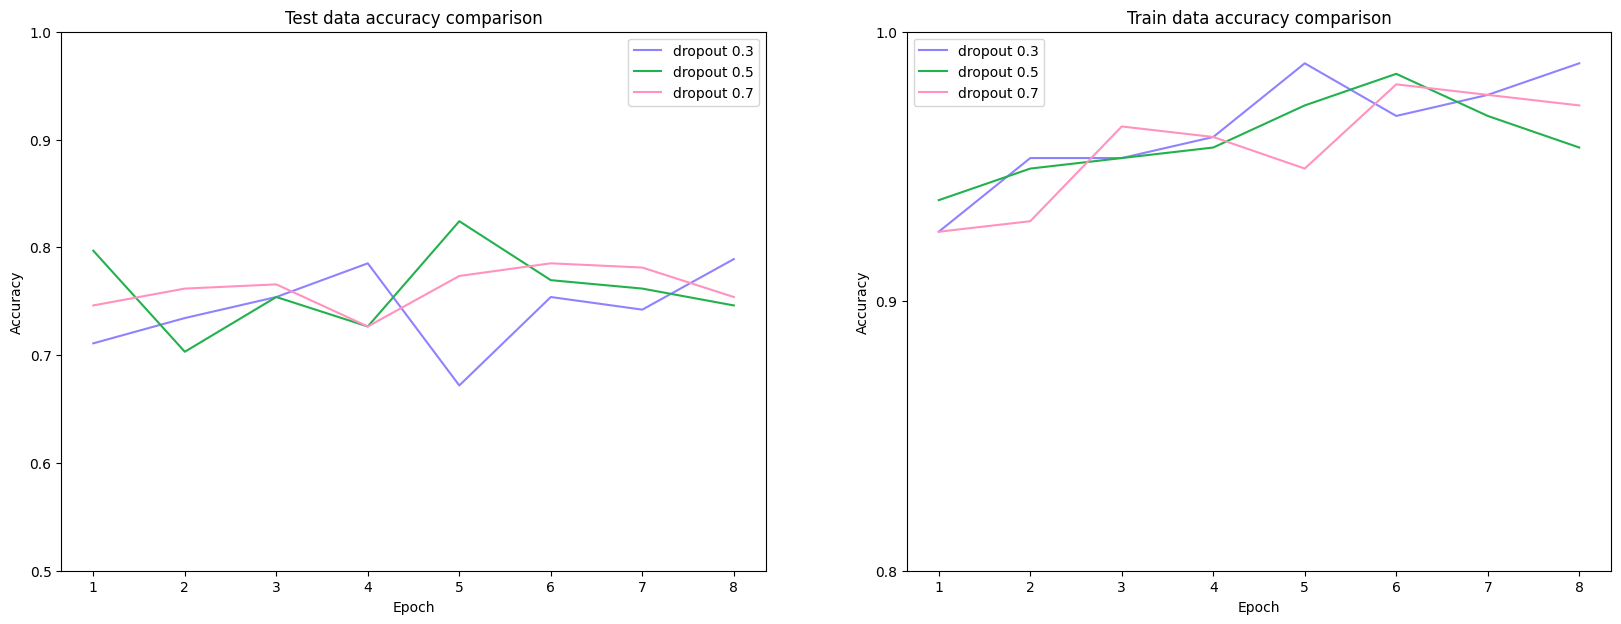

In [ ]:
folder_path = "/content/drive/MyDrive/프로젝트/result"
file_list = os.listdir(folder_path)
date = {'02-01': pd.DataFrame(), '02-22': pd.DataFrame(), '02-25': pd.DataFrame(), '02-26': pd.DataFrame(), '02-27': pd.DataFrame()}

for i in range (len(file_list)):
  if ".csv" in file_list[i]:
    data = pd.read_csv(f"{folder_path}/{file_list[i]}")
    if file_list[i][26:31] in date:
      date[file_list[i][26:31]] = pd.concat([date[file_list[i][26:31]], data],ignore_index = True)
model3_ans = date['02-01'].groupby("Epoch").mean()
model4_ans = date['02-25'].groupby("Epoch").mean()
model5_ans = date['02-26'].groupby("Epoch").mean()
model6_ans = date['02-27'].groupby("Epoch").mean()
x =[i for i in range(1,9)]
y1 = model3_ans["Accuracy_test"]
y3 = model4_ans["Accuracy_test"]
y4 = model5_ans["Accuracy_test"]
y5 = model6_ans["Accuracy_test"]
y11 = model3_ans["Accuracy_train"]
y33 = model4_ans["Accuracy_train"]
y44 = model5_ans["Accuracy_train"]
y55 = model6_ans["Accuracy_train"]
plt.figure(figsize = (20,7))

plt.subplot(1,2,1)
plt.plot(x,y5, color = "#8F82FF", label='dropout 0.3')
plt.plot(x,y3, color = "#22B14C", label='dropout 0.5')
plt.plot(x,y4, color = "#FF92BF", label='dropout 0.7')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.yticks([i * 0.1 for i in range(5,11)])
plt.xticks([(i+1) * 1.0 for i in range(len(data["Epoch"]))])
plt.legend()
plt.title("Test data accuracy comparison")

plt.subplot(1,2,2)
plt.plot(x,y55, color = "#8F82FF", label='dropout 0.3')
plt.plot(x,y33, color = "#22B14C", label='dropout 0.5')
plt.plot(x,y44, color = "#FF92BF", label='dropout 0.7')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.yticks([i * 0.1 for i in range(8,11)])
plt.xticks([(i+1) * 1.0 for i in range(len(data["Epoch"]))])
plt.legend()
plt.title("Train data accuracy comparison")

plt.savefig("Accuracy comparison of test data & train data of model 4, 5 and 6")
plt.show()

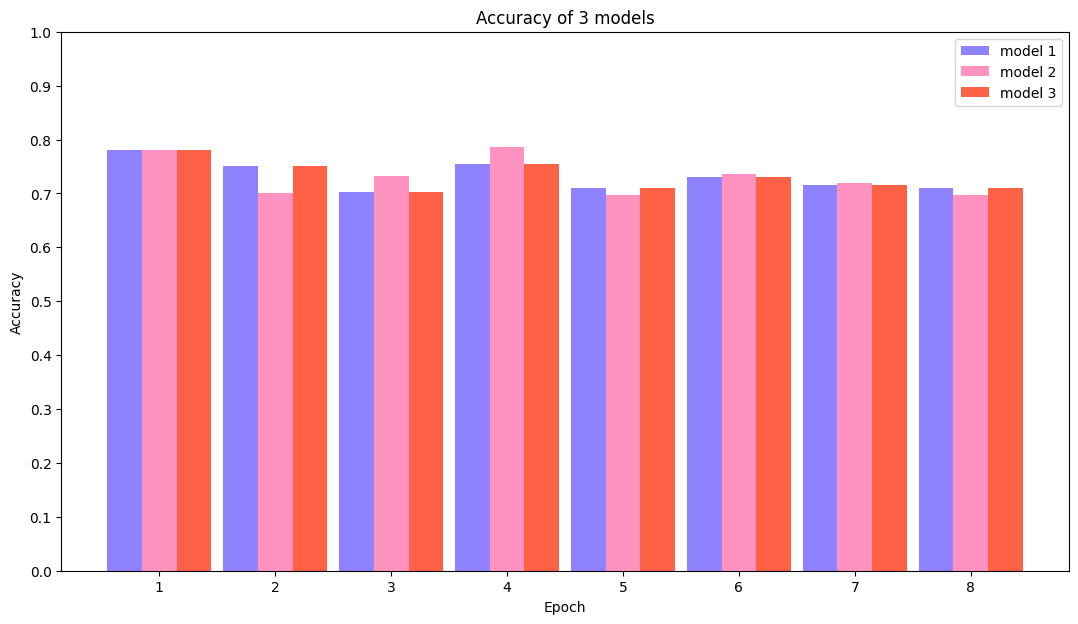

In [ ]:
folder_path = "/content/drive/MyDrive/프로젝트/result"
file_list = os.listdir(folder_path)
date = {'02-05': pd.DataFrame(), '01-29' : pd.DataFrame(), "02-01" : pd.DataFrame()}

for i in range (len(file_list)):
  if ".csv" in file_list[i]:
    data = pd.read_csv(f"{folder_path}/{file_list[i]}")
    if file_list[i][26:31] in date:
      date[file_list[i][26:31]] = pd.concat([date[file_list[i][26:31]], data],ignore_index = True)
model1_ans = date['02-05'].groupby("Epoch").mean()
model2_ans = date['01-29'].groupby("Epoch").mean()
model3_ans = date['02-01'].groupby("Epoch").mean()
x =[i for i in range(1,9)]
y1 = model1_ans["Accuracy_test"]
y2 = model2_ans["Accuracy_test"]
y3 = model3_ans["Accuracy_test"]
plt.figure(figsize = (13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of 3 models")
plt.ylim(0,1)
plt.yticks([i * 0.1 for i in range(11)])
plt.bar([i-0.3 for i in x],y1,width = 0.3, color = "#8F82FF", label='model 1')
plt.bar(x,y2,width = 0.3, color = "#FF92BF", label='model 2')
plt.bar([i+0.3 for i in x],y1,width = 0.3, color = "#FF6147", label = 'model 3')
plt.legend()
plt.savefig("Accuracy of 3 models.png")
plt.show()

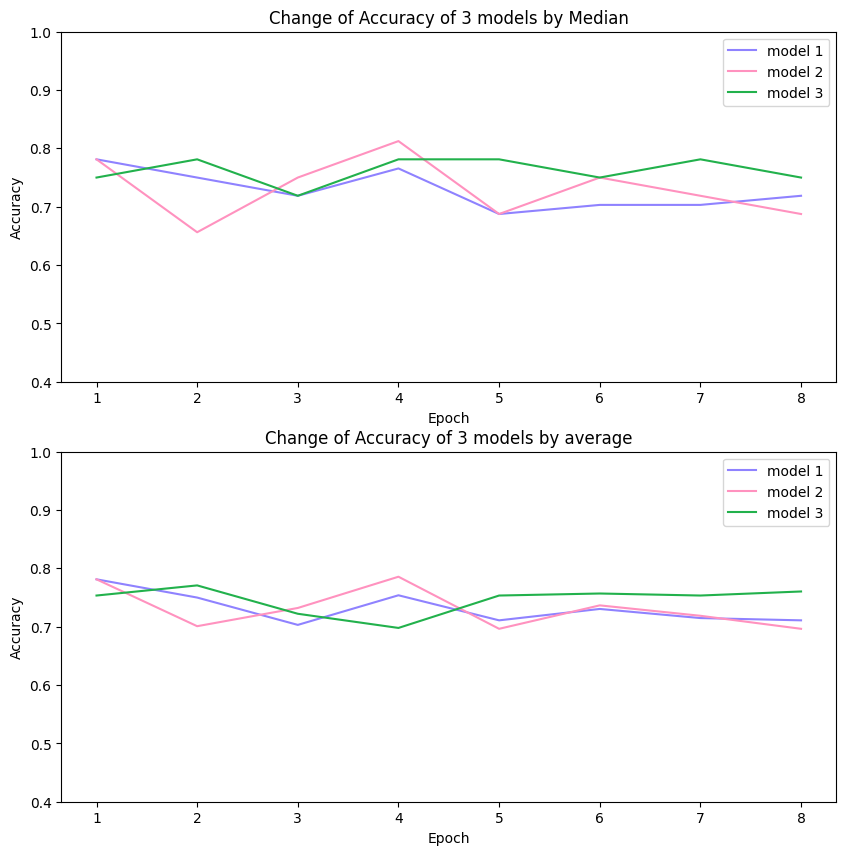

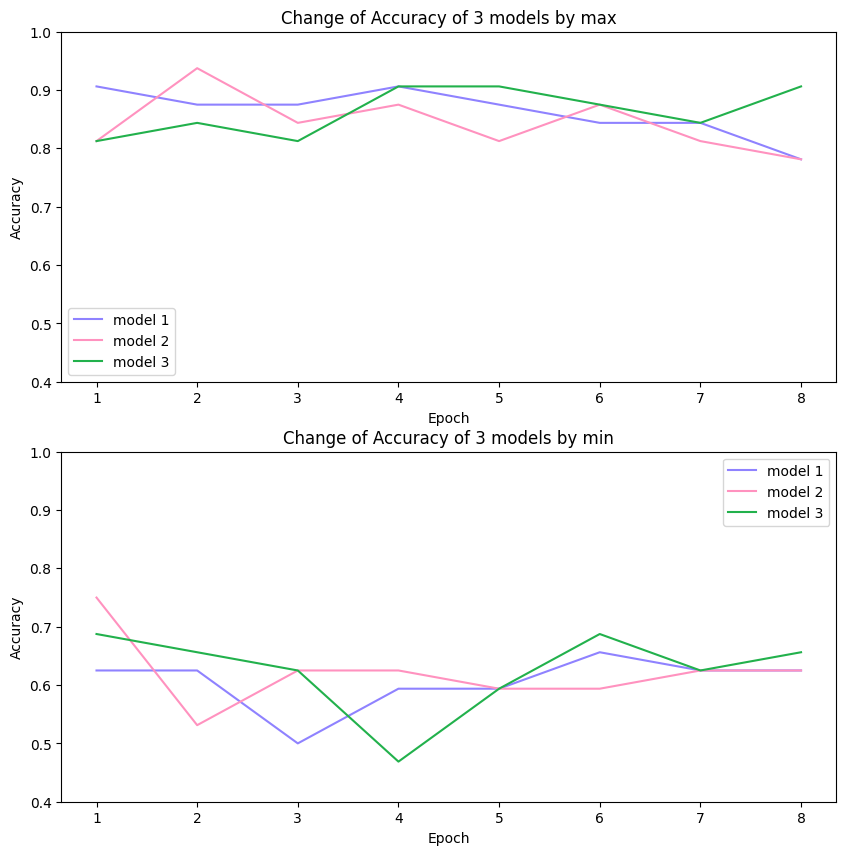

In [ ]:
x =[i for i in range(1,9)]
y1 = model1_ans["Accuracy_test"]
y2 = model2_ans["Accuracy_test"]
y3 = model3_ans["Accuracy_test"]
model1_mid = date['02-05'].groupby("Epoch").median()
model2_mid = date['01-29'].groupby("Epoch").median()
model3_mid = date['02-01'].groupby("Epoch").median()
y11 = model1_mid["Accuracy_test"]
y22 = model2_mid["Accuracy_test"]
y33 = model3_mid["Accuracy_test"]
model1_max = date['02-05'].groupby("Epoch").max()
model2_max = date['01-29'].groupby("Epoch").max()
model3_max = date['02-01'].groupby("Epoch").max()
y1max = model1_max["Accuracy_test"]
y2max = model2_max["Accuracy_test"]
y3max = model3_max["Accuracy_test"]
model1_min = date['02-05'].groupby("Epoch").min()
model2_min = date['01-29'].groupby("Epoch").min()
model3_min = date['02-01'].groupby("Epoch").min()
y1min = model1_min["Accuracy_test"]
y2min = model2_min["Accuracy_test"]
y3min = model3_min["Accuracy_test"]
plt.figure(figsize = (10,10))

plt.subplot(2,1,1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Change of Accuracy of 3 models by Median")
plt.ylim(0.4,1)
plt.yticks([i * 0.1 for i in range(4,11)])
plt.plot(x,y11,color = "#8F82FF", label='model 1')
plt.plot(x,y22,color = "#FF92BF", label='model 2')
plt.plot(x,y33,color = "#22B14C", label = 'model 3')
plt.legend()


plt.subplot(2,1,2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Change of Accuracy of 3 models by average")
plt.ylim(0.4,1)
plt.yticks([i * 0.1 for i in range(4,11)])
plt.plot(x,y1,color = "#8F82FF", label='model 1')
plt.plot(x,y2,color = "#FF92BF", label='model 2')
plt.plot(x,y3,color = "#22B14C", label = 'model 3')
plt.legend()
plt.savefig("Change of Accuracy of 3 models1.png")
plt.show()

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Change of Accuracy of 3 models by max")
plt.ylim(0.4,1)
plt.yticks([i * 0.1 for i in range(4,11)])
plt.plot(x,y1max,color = "#8F82FF", label='model 1')
plt.plot(x,y2max,color = "#FF92BF", label='model 2')
plt.plot(x,y3max,color = "#22B14C", label = 'model 3')
plt.legend()


plt.subplot(2,1,2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Change of Accuracy of 3 models by min")
plt.ylim(0.4,1)
plt.yticks([i * 0.1 for i in range(4,11)])
plt.plot(x,y1min,color = "#8F82FF", label='model 1')
plt.plot(x,y2min,color = "#FF92BF", label='model 2')
plt.plot(x,y3min,color = "#22B14C", label = 'model 3')
plt.legend()

plt.savefig("Change of Accuracy of 3 models2.png")
plt.show()

In [ ]:
def result(chkmodel,loader):
  chkmodel.eval()
  with torch.no_grad():
    dataiter = iter(loader)
    images, labels = dataiter.__next__()

    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    _, predicted = torch.max(outputs,1)

    for i in range(len(images)):
      if predicted[i].item() == 1:
        print(labels[i],predicted[i])
        display_image = images[i].permute(1,2,0).cpu().numpy()
        dosplay_image = np.clip(display_image*255,0,255).astype(np.uint8)

        image_with_overlay = np.zeros((224, 224, 3), dtype=np.uint8)

        image_with_overlay[:, :, 0] = 255  # R 채널을 모두 255로 설정하여 빨간색 생성
        # 원래 이미지와 오버레이 이미지를 합성하여 표시
        plt.imshow(display_image)  # original_image는 원래 이미지 텐서입니다.
        plt.imshow(image_with_overlay, alpha=0.5)  # 오버레이 이미지를 반투명하게 합성하여 표시
        plt.axis('off')
        plt.show()
  chkmodel.train()



tensor(1) tensor(1)


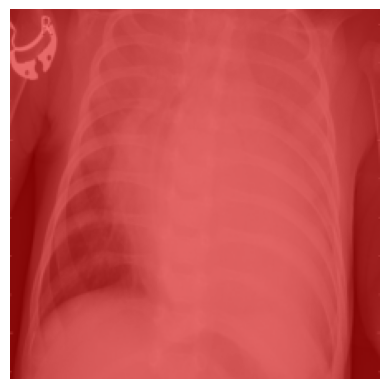

tensor(0) tensor(1)


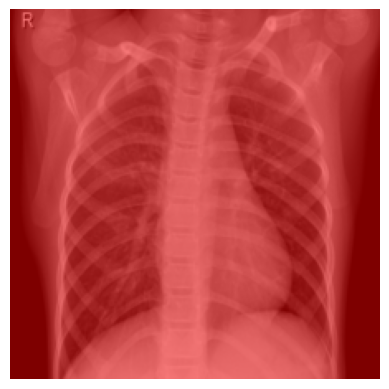

tensor(1) tensor(1)


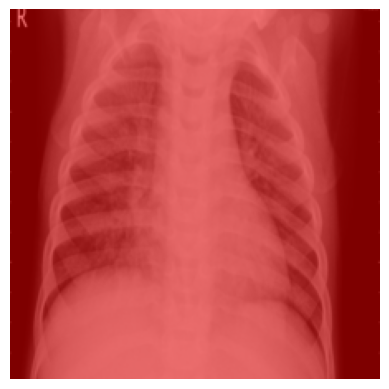

tensor(1) tensor(1)


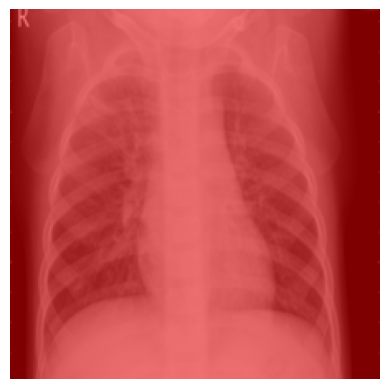

tensor(0) tensor(1)


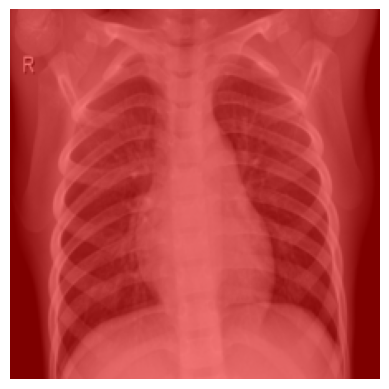

tensor(0) tensor(1)


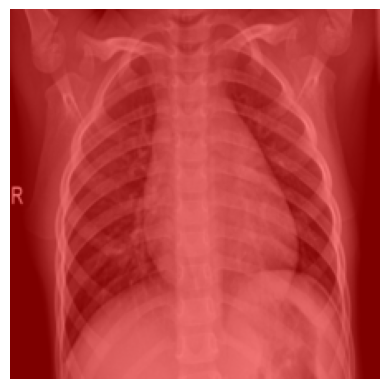

tensor(1) tensor(1)


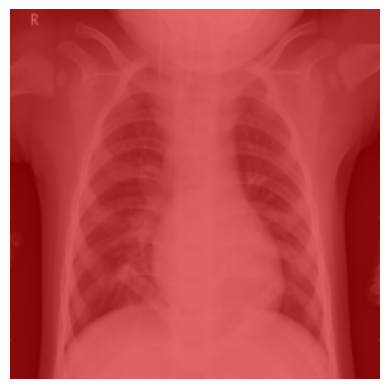

tensor(0) tensor(1)


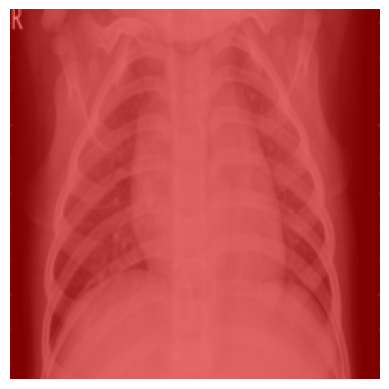

tensor(1) tensor(1)


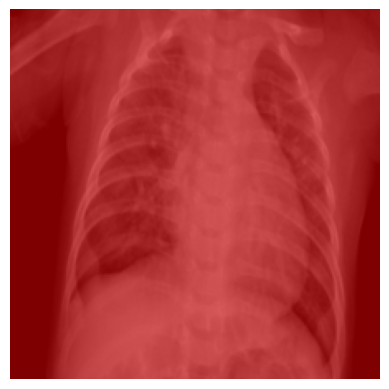

tensor(1) tensor(1)


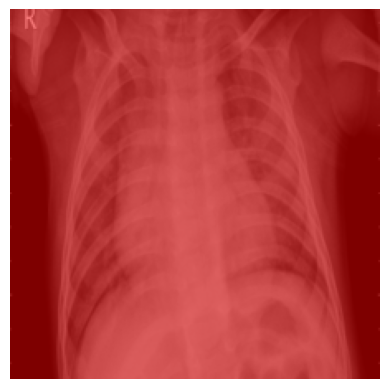

tensor(1) tensor(1)


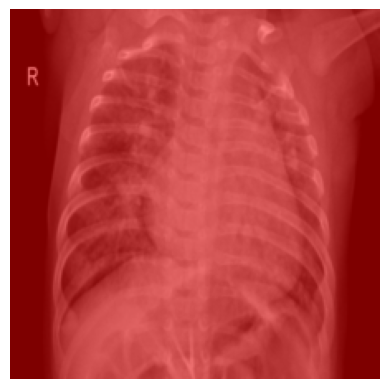

tensor(0) tensor(1)


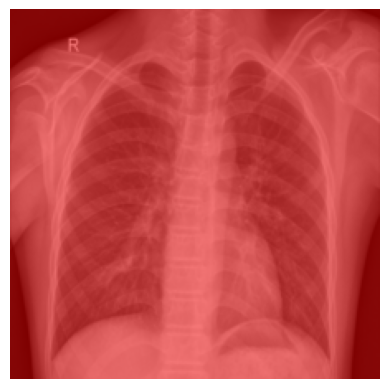

tensor(1) tensor(1)


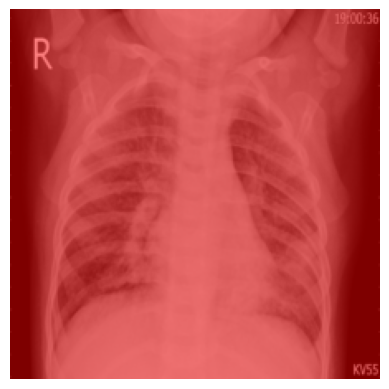

tensor(1) tensor(1)


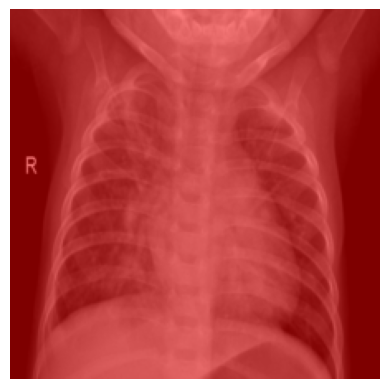

tensor(0) tensor(1)


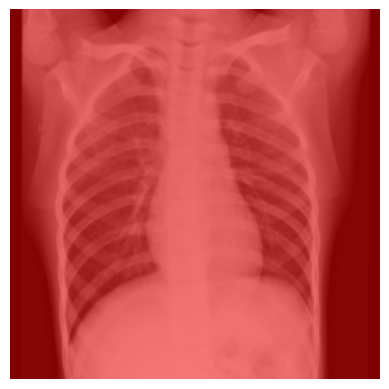

tensor(1) tensor(1)


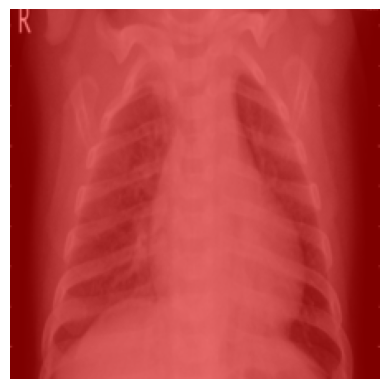

tensor(1) tensor(1)


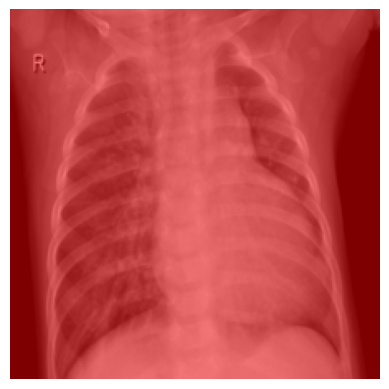

tensor(0) tensor(1)


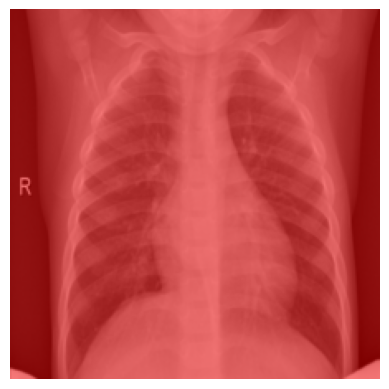

tensor(1) tensor(1)


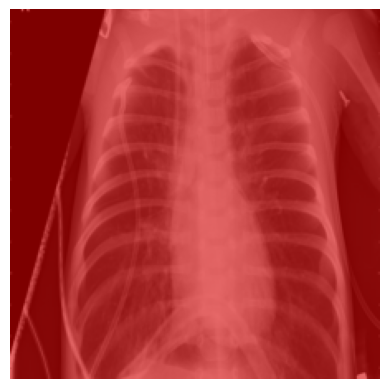

tensor(1) tensor(1)


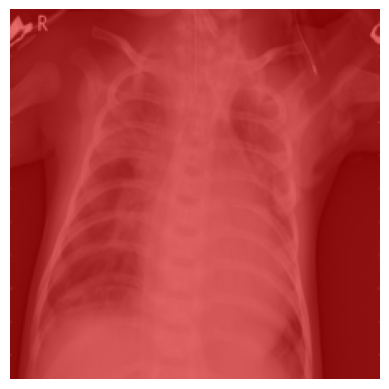

tensor(0) tensor(1)


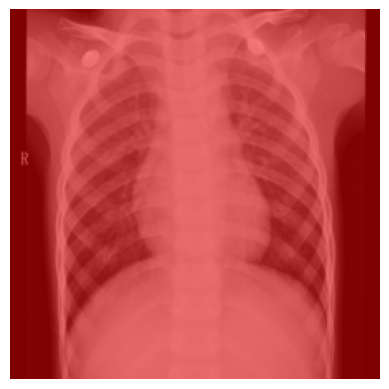

tensor(1) tensor(1)


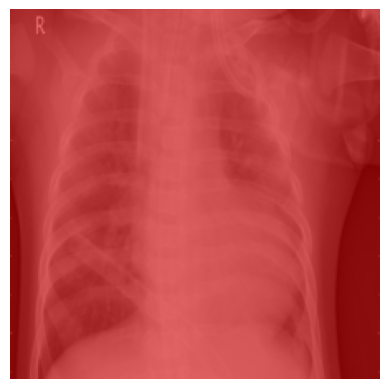

tensor(0) tensor(1)


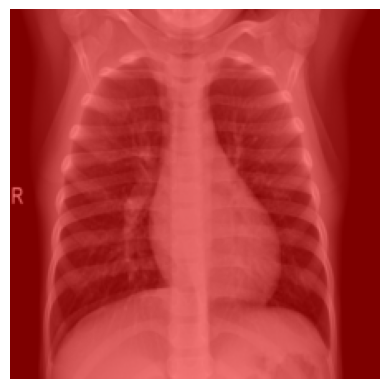

tensor(1) tensor(1)


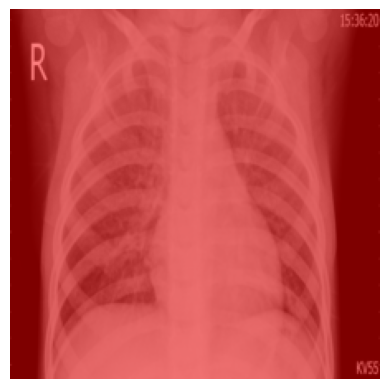

tensor(0) tensor(1)


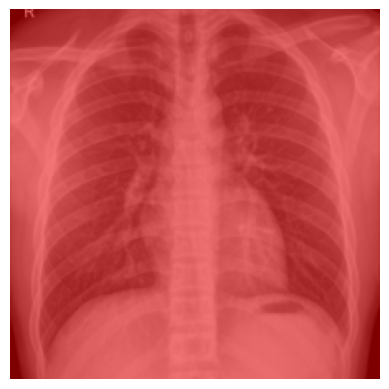

tensor(1) tensor(1)


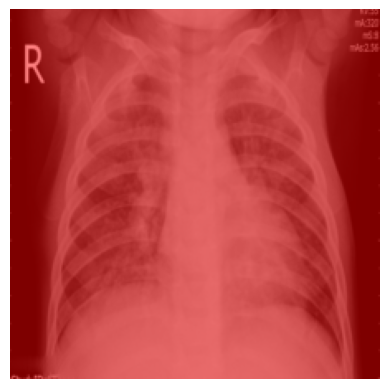

tensor(1) tensor(1)


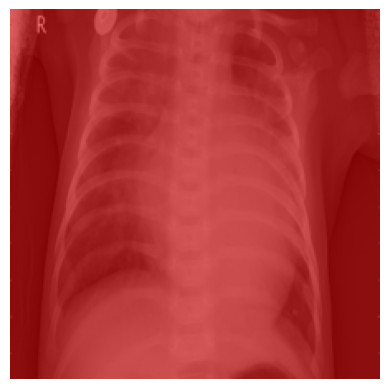

tensor(1) tensor(1)


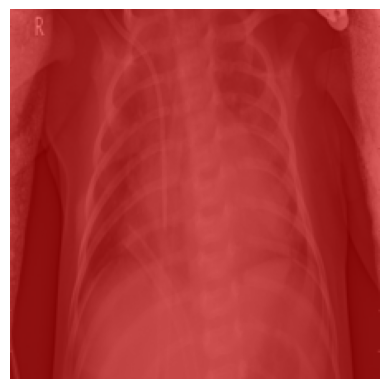

"\n# 모델이 예측한 클래스\npredicted_class = 1  # 이 값은 예시로 설정되었습니다.\n\n# 만약 모델이 폐렴을 감지했다고 가정하고 병변 부분을 표시할 이미지를 생성합니다.\nif predicted_class == 1:\n    # 여기서는 임의의 크기의 빨간색 사각형을 생성합니다.\n    # 병변 부분을 표시하는 방법은 실제 데이터 및 모델의 예측에 따라 다를 수 있습니다.\n    # 이 예시에서는 빨간색 사각형을 생성합니다.\n    image_with_overlay = np.zeros((224, 224, 3), dtype=np.uint8)\n    image_with_overlay[:, :, 0] = 255  # R 채널을 모두 255로 설정하여 빨간색 생성\n\n    # 원래 이미지와 오버레이 이미지를 합성하여 표시\n    plt.imshow(original_image)  # original_image는 원래 이미지 텐서입니다.\n    plt.imshow(image_with_overlay, alpha=0.5)  # 오버레이 이미지를 반투명하게 합성하여 표시\n    plt.axis('off')\n    plt.show()\n"

In [ ]:
result(model,test_loader)
'''
# 모델이 예측한 클래스
predicted_class = 1  # 이 값은 예시로 설정되었습니다.

# 만약 모델이 폐렴을 감지했다고 가정하고 병변 부분을 표시할 이미지를 생성합니다.
if predicted_class == 1:
    # 여기서는 임의의 크기의 빨간색 사각형을 생성합니다.
    # 병변 부분을 표시하는 방법은 실제 데이터 및 모델의 예측에 따라 다를 수 있습니다.
    # 이 예시에서는 빨간색 사각형을 생성합니다.
    image_with_overlay = np.zeros((224, 224, 3), dtype=np.uint8)
    image_with_overlay[:, :, 0] = 255  # R 채널을 모두 255로 설정하여 빨간색 생성

    # 원래 이미지와 오버레이 이미지를 합성하여 표시
    plt.imshow(original_image)  # original_image는 원래 이미지 텐서입니다.
    plt.imshow(image_with_overlay, alpha=0.5)  # 오버레이 이미지를 반투명하게 합성하여 표시
    plt.axis('off')
    plt.show()
'''